In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model='models/embedding-001'
)

vec = embeddings.embed_query("Hello, world!")
len(vec)

768

In [3]:
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore

In [4]:
pc = Pinecone()
pc

In [5]:
index = pc.Index("rag-llama")

vector_store = PineconeVectorStore(
    index=index,
    embedding=embeddings,
    text_key="text" 
)

In [6]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [7]:
retriever.invoke("How to finetune Llama?")

[Document(id='660aa298-8d44-4336-bb4d-8494d00969a2', metadata={'author': '', 'creationdate': '2023-07-20T00:30:36+00:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2023-07-20T00:30:36+00:00', 'page': 12.0, 'page_label': '13', 'producer': 'pdfTeX-1.40.25', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'source': '../llama2.pdf', 'subject': '', 'title': '', 'total_pages': 77.0, 'trapped': '/False'}, page_content='Therefore, everything else being equal, an improvement of the reward model can be directly translated into\nan improvement forLlama 2-Chat.\n3.2.3 Iterative Fine-Tuning\nAs we received more batches of human preference data annotation, we were able to train better reward\nmodels and collect more prompts. We therefore trained successive versions for RLHF models, referred to\nhere as RLHF-V1, ..., RLHF-V5.\nWe explored RLHF fine-tuning with two main algorithms:'),
 Document(id='0ad837ac-0c87-4a33-9d94

In [8]:
## Great LLM
# from langchain_anthropic.chat_models import ChatAnthropic

# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
# llm

In [9]:
# from langchain_google_genai import ChatGoogleGenerativeAI

# llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
# llm

In [10]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(
#     model = 'gpt-4o'
# )

# llm

In [11]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model = 'gemma2-9b-it'
)

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001E773F49730>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E773EA3EF0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [12]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [13]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [14]:
from langchain.output_parsers import PydanticOutputParser

In [15]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [16]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [17]:

def classify_query_topic(state: AgentState) -> dict:
    print("-> Classify Query Topic ->")
    
    query = state["messages"][-1]
    print("User query:", query)
    
    template = """
    You are an intelligent AI assistant.

    Your task is to classify whether the given user query is related to the LLaMA 2 research paper by Meta.

    The paper includes information about LLaMA 2's architecture, training data, pretraining, fine-tuning, safety evaluation, licensing, deployment, and limitations.

    Based on the query content, decide:
    - "Related": if the query asks about topics covered in the paper.
    - "Not Related": if the query is unrelated or general.

    Return your output in the following JSON format:

    {format_instructions}

    User Query:
    {query}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["query"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | llm | parser

    # Debug print raw LLM response
    raw_output = llm.invoke(prompt.format(query=query)).content
    print("🪵 Raw LLM output:\n", raw_output)

    # Parse output safely
    response = chain.invoke({"query": query})
    print("✅ Parsed response:", response)

    return {"messages": [response.Topic]}

In [18]:
state = {"messages":["what is a today weather?"]}
classify_query_topic(state)

-> Classify Query Topic ->
User query: what is a today weather?
🪵 Raw LLM output:
 ```json
{
 "Topic": "Not Related",
 "Reasoning": "The query asks about the weather, which is unrelated to the LLaMA 2 research paper."
}
```
✅ Parsed response: Topic='Not Related' Reasoning='The query asks about the weather, which is unrelated to the LLaMA 2 research paper.'


{'messages': ['Not Related']}

In [19]:
state = {"messages":[
    """
    How do sequence truncation artifacts at the end of fixed-length contexts affect token-level loss distribution during LLM pretraining, 
    and what mitigation strategies can be employed to reduce the 'final token loss spike' bias?
    """
]}

classify_query_topic(state)

-> Classify Query Topic ->
User query: 
    How do sequence truncation artifacts at the end of fixed-length contexts affect token-level loss distribution during LLM pretraining, 
    and what mitigation strategies can be employed to reduce the 'final token loss spike' bias?
    
🪵 Raw LLM output:
 ```json
{
 "Topic": "LLaMA 2 Pretraining",
 "Reasoning": "The query specifically discusses sequence truncation artifacts and their impact on token-level loss distribution during pretraining, which are key aspects covered in the LLaMA 2 research paper."
}
```
✅ Parsed response: Topic='Related' Reasoning='The query delves into the technical aspects of LLM pretraining, specifically addressing sequence truncation artifacts and their impact on token-level loss distribution. This aligns with the discussion on training methodologies and potential challenges outlined in the LLaMA 2 research paper.'


{'messages': ['Related']}

In [20]:
def router(state: AgentState) -> str:
    print("-> ROUTER ->")

    last_message = state["messages"][-1]
    print("last_message:", last_message)

    if last_message == "Related":
        return "RAG Call"
    else:
        return "LLM Call"


In [21]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [22]:
# RAG Function
def rag_call(state:AgentState) -> dict:
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    print("Question to RAG:", question)
    
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    
    return  {"messages": [result]}

In [23]:

def llm_call(state: AgentState) -> dict:
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    print("Question to LLM:", question)
    
    llm_prompt_template = """
    You are a friendly and intelligent AI assistant.

    Respond helpfully to the user's message below. You can answer any type of question — technical, general knowledge, creative, or casual — just like a helpful assistant would in a natural conversation.

    User:
    {question}
    """

    llm_prompt = PromptTemplate(
        input_variables=["question"],
        template=llm_prompt_template
    )

    complete_prompt = llm_prompt.format(question=question)

    response = llm.invoke(complete_prompt)

    return {"messages": [response.content]}

In [24]:
workflow = StateGraph(AgentState)

In [25]:
workflow.add_node("Supervisor", classify_query_topic)
workflow.add_node("RAG", rag_call)
workflow.add_node("LLM", llm_call)

In [26]:
workflow.set_entry_point("Supervisor")

In [27]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

In [28]:
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)

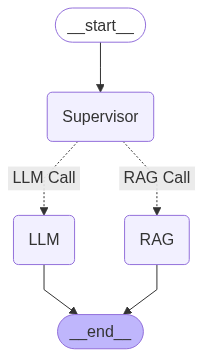

In [29]:
app = workflow.compile()
app

In [30]:
state = {"messages":[
    """
    How do sequence truncation artifacts at the end of fixed-length contexts affect token-level loss distribution during LLM pretraining, 
    and what mitigation strategies can be employed to reduce the 'final token loss spike' bias?
    """
]}

response = app.invoke(state)
response

-> Classify Query Topic ->
User query: 
    How do sequence truncation artifacts at the end of fixed-length contexts affect token-level loss distribution during LLM pretraining, 
    and what mitigation strategies can be employed to reduce the 'final token loss spike' bias?
    
🪵 Raw LLM output:
 ```json
{
 "Topic": "Related",
 "Reasoning": "The query delves into the technical aspects of LLaMA 2's training process, specifically addressing sequence truncation artifacts and their impact on token-level loss distribution. These are topics likely discussed in the research paper." 
}
```
✅ Parsed response: Topic='Related' Reasoning="The query delves into the technical aspects of LLM pretraining, specifically addressing sequence truncation artifacts and their impact on loss distribution. This aligns with the LLaMA 2 paper's discussion on training methodologies and potential challenges."
-> ROUTER ->
last_message: Related
-> RAG Call ->
Question to RAG: 
    How do sequence truncation artifac

{'messages': ["\n    How do sequence truncation artifacts at the end of fixed-length contexts affect token-level loss distribution during LLM pretraining, \n    and what mitigation strategies can be employed to reduce the 'final token loss spike' bias?\n    ",
  'Related',
  "The provided context does not contain information about sequence truncation artifacts or mitigation strategies for 'final token loss spike' bias. Therefore, I cannot answer your question.  The text focuses on context length expansion and context distillation techniques in Llama 2. \n"]}

In [31]:
print(response['messages'][-1])

The provided context does not contain information about sequence truncation artifacts or mitigation strategies for 'final token loss spike' bias. Therefore, I cannot answer your question.  The text focuses on context length expansion and context distillation techniques in Llama 2. 



In [32]:
state = {"messages":[
    """
    What kind of alignment techniques and safety evaluations were used before releasing the open-weight language models?
    """
]}

response = app.invoke(state)
response

-> Classify Query Topic ->
User query: 
    What kind of alignment techniques and safety evaluations were used before releasing the open-weight language models?
    
🪵 Raw LLM output:
 ```json
{"Topic": "Related", "Reasoning": "The query asks about safety evaluations and alignment techniques used in the development of open-weight language models, which are topics directly addressed in the LLaMA 2 research paper."}
```
✅ Parsed response: Topic='Related' Reasoning='The query asks about safety evaluations and alignment techniques used in the development of open-weight language models, which are topics discussed in the LLaMA 2 research paper.'
-> ROUTER ->
last_message: Related
-> RAG Call ->
Question to RAG: 
    What kind of alignment techniques and safety evaluations were used before releasing the open-weight language models?
    


{'messages': ['\n    What kind of alignment techniques and safety evaluations were used before releasing the open-weight language models?\n    ',
  'Related',
  "The provided text describes safety evaluations using human reviews of adversarial prompts and  in-house Safety and Helpfulness reward models.  It mentions techniques like Supervised Fine-Tuning (SFT) and Reinforcement Learning from Human Feedback (RLHF) were used to improve the model's safety.  Specific details about the alignment techniques are not elaborated upon. \n\n\n"]}

In [33]:
print(response['messages'][-1])

The provided text describes safety evaluations using human reviews of adversarial prompts and  in-house Safety and Helpfulness reward models.  It mentions techniques like Supervised Fine-Tuning (SFT) and Reinforcement Learning from Human Feedback (RLHF) were used to improve the model's safety.  Specific details about the alignment techniques are not elaborated upon. 





In [38]:
messages = [HumanMessage(content="""
                        What is NATO, and when was it formed? Does NATO still hold strategic significance even after the collapse of the USSR and 
                        considering Russia's relatively weaker economy compared to the U.S. and Europe? Some argue that NATO now serves more as a 
                        display of Western power and may even pose a threat to global peace. What are your thoughts on this perspective — especially given 
                        the unpredictability of nations that feel cornered or powerless? You probably know who I'm referring to.
                        """)]

state: AgentState = {"messages": messages}

response = app.invoke(state)
response

-> Classify Query Topic ->
User query: content="\n                        What is NATO, and when was it formed? Does NATO still hold strategic significance even after the collapse of the USSR and \n                        considering Russia's relatively weaker economy compared to the U.S. and Europe? Some argue that NATO now serves more as a \n                        display of Western power and may even pose a threat to global peace. What are your thoughts on this perspective — especially given \n                        the unpredictability of nations that feel cornered or powerless? You probably know who I'm referring to.\n                        " additional_kwargs={} response_metadata={}
🪵 Raw LLM output:
 ```json
{"Topic": "Not Related", "Reasoning": "The user query is about NATO, its history, and strategic significance. This topic is unrelated to the LLaMA 2 research paper by Meta."}
```
✅ Parsed response: Topic='Not Related' Reasoning="The query is about NATO's history, strategi

{'messages': [HumanMessage(content="\n                        What is NATO, and when was it formed? Does NATO still hold strategic significance even after the collapse of the USSR and \n                        considering Russia's relatively weaker economy compared to the U.S. and Europe? Some argue that NATO now serves more as a \n                        display of Western power and may even pose a threat to global peace. What are your thoughts on this perspective — especially given \n                        the unpredictability of nations that feel cornered or powerless? You probably know who I'm referring to.\n                        ", additional_kwargs={}, response_metadata={}),
  'Not Related',
  "That's a great question, and it touches on some really important and complex geopolitical issues! \n\nLet me break down your question about NATO:\n\n**What is NATO, and when was it formed?**\n\nNATO stands for the North Atlantic Treaty Organization. It's a political and military allianc

In [39]:
print(response['messages'][-1])

That's a great question, and it touches on some really important and complex geopolitical issues! 

Let me break down your question about NATO:

**What is NATO, and when was it formed?**

NATO stands for the North Atlantic Treaty Organization. It's a political and military alliance formed in 1949 by 12 countries, primarily from North America and Western Europe. The main goal was to provide collective security against the perceived threat of the Soviet Union during the Cold War.

**Does NATO still hold strategic significance?**

That's where things get interesting.  While the Soviet Union collapsed in 1991, NATO has continued to evolve and adapt. Many argue that it remains strategically significant for several reasons:

* **Collective Defense:** The core principle of NATO – an attack on one member is an attack on all – still provides a strong deterrent against aggression.
* **Regional Stability:**  NATO has played a role in stabilizing regions like the Balkans and Eastern Europe after t